<a href="https://colab.research.google.com/github/Soumi7/TFNotebooks/blob/master/TransferLYoga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
import seaborn as sns

import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow
print(tensorflow.__version__)
import tensorflow_addons
print(tensorflow_addons.__version__)


2.2.0-rc3
0.8.3


In [0]:
NUM_CLASSES = 5

# Fixed for color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 10
BATCH_SIZE_VALIDATION = 10

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Text(0.5, 1.0, 'Number of training images per Pose Category')

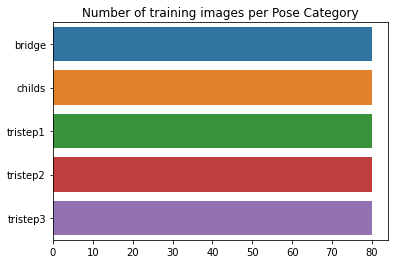

In [12]:
train_data_dir="drive/My Drive/data/training_set"
val_data_dir="drive/My Drive/data/validation_set"
test_data_dir="drive/My Drive/data/test_set"
category_names= sorted(os.listdir("drive/My Drive/data/training_set"))
nb_categories= len(category_names)
img_per_cat=[]
for category in category_names:
  folder = 'drive/My Drive/data/training_set' + '/' + category
  img_per_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names,x=img_per_cat).set_title("Number of training images per Pose Category")

In [0]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [0]:
resnet_weights_path = 'drive/My Drive/data/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [0]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

model.layers[0].trainable = False

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [18]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')
validation_generator = data_generator.flow_from_directory(
        val_data_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Using TensorFlow backend.


Found 399 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [19]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(10, 40, 10, 5)

In [0]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'drive/My Drive/best1.h5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [21]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
10/10 [==============================] - 105s 11s/step - loss: 4.3775 - accuracy: 0.3300 - val_loss: 2.9603 - val_accuracy: 0.4600
Epoch 2/10
10/10 [==============================] - 80s 8s/step - loss: 2.6454 - accuracy: 0.5600 - val_loss: 2.2187 - val_accuracy: 0.5900
Epoch 3/10
10/10 [==============================] - 70s 7s/step - loss: 1.7105 - accuracy: 0.7300 - val_loss: 2.4015 - val_accuracy: 0.6400
Epoch 4/10
10/10 [==============================] - 68s 7s/step - loss: 2.4466 - accuracy: 0.7273 - val_loss: 1.8719 - val_accuracy: 0.6900
Epoch 5/10
10/10 [==============================] - 22s 2s/step - loss: 0.5036 - accuracy: 0.8600 - val_loss: 2.1540 - val_accuracy: 0.6100
Epoch 6/10
10/10 [==============================] - 22s 2s/step - loss: 0.5451 - accuracy: 0.9100 - val_loss: 3.1096 - val_accuracy: 0.7000
Epoch 7/10
10/10 [==============================] - 22s 2s/step - loss: 1.1263 - a

In [15]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


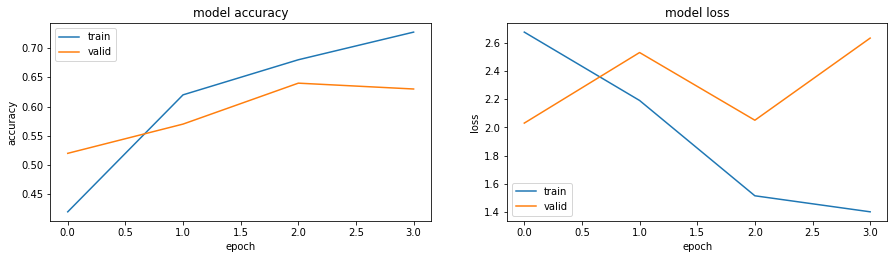

In [16]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()


In [17]:
test_generator = data_generator.flow_from_directory(
    directory = test_data_dir,
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 50 images belonging to 5 classes.


In [18]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
50/50 [==============================] - 30s 607ms/step


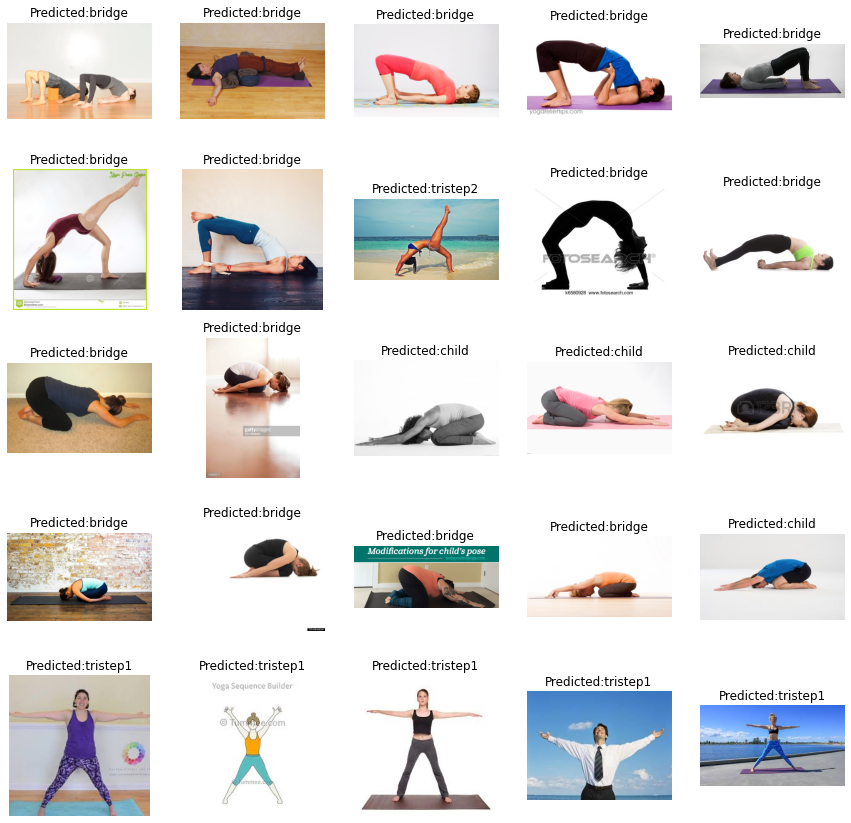

In [19]:
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread("drive/My Drive/data/test_set/" + test_generator.filenames[i])
    #print("drive/My Drive/data/test_set" + test_generator.filenames[i])
    #print(imgBGR)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = ("bridge", "child","tristep1","tristep2","tristep3")[predicted_class_indices[i]]

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()

In [20]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)
results_df.head()

,id,label
24,1,2
28,1,2
27,1,2
26,1,2
25,1,2
